# This notebook will train the model perform predictions on the test data

In [7]:
#import libraries and the functions we defined
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from Networks.metrics import dice_coef, jaccard_distance
from Networks import models
from sklearn.model_selection import train_test_split
from Networks.switchnorm import SwitchNormalization
import fnmatch
import nibabel as nib
from Data_Gen_2D import DataGenerator

In [8]:
#Activate GPU
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
#get the dataset path, input and masks
def get_file_and_path(data_path, phrase):
    set_of = [os.path.join(data_path, f) for f in os.listdir(data_path) if phrase in f]
    return set_of

In [10]:
#define the input image and mask locations
data_path_1 = r"D:\Lung\Keras\npy1\\"
#use the function to collect all input images
images = get_file_and_path(data_path_1, '_M')
print(len(images))

#similarly gather all the masks
labels = get_file_and_path(data_path_1, '_K')
print(len(labels))


10334
10334


D:\Lung\Keras\npy1\\W6_ET649F_218_K.npy


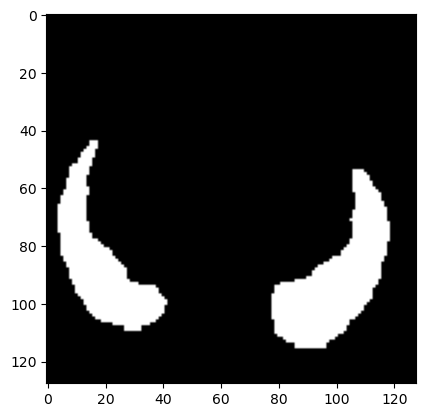

In [11]:
#check if the mask name and image are proper
%matplotlib inline
print(labels[-150])
image = np.load(labels[-150])
plt.imshow(image, cmap='gray')

In [12]:
#map the masks to the corresponding input images
labels = {image: i for i, image in enumerate(images)}
print(len(labels))

10334


In [13]:
#backup
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

## Train, Validation Split
###### Make sure you have seperate unseen test dataset

In [14]:
# getting the patient id list
id_list = [os.path.basename(image)[:11] for image in images]
unique_ids = list(set(id_list))
print(len(unique_ids))
# Splitting data into train and validation sets
train_ids, val_ids = train_test_split(unique_ids, train_size=0.8)

train_list = [image for image in images if any(phrase in image for phrase in train_ids)]
val_list = [image for image in images if any(phrase in image for phrase in val_ids)]
partition = {'train': train_list, 'validation': val_list}
print(len(train_ids))
print(len(val_ids))
print(len(train_list))
print(len(val_list))

370
296
74
8196
2138


# Set up Training Environment 

In [15]:
params = {'dim': (128,128),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 128, 128, 1) (32, 128, 128, 2)


## Visualize if images are correctly mapped with their masks

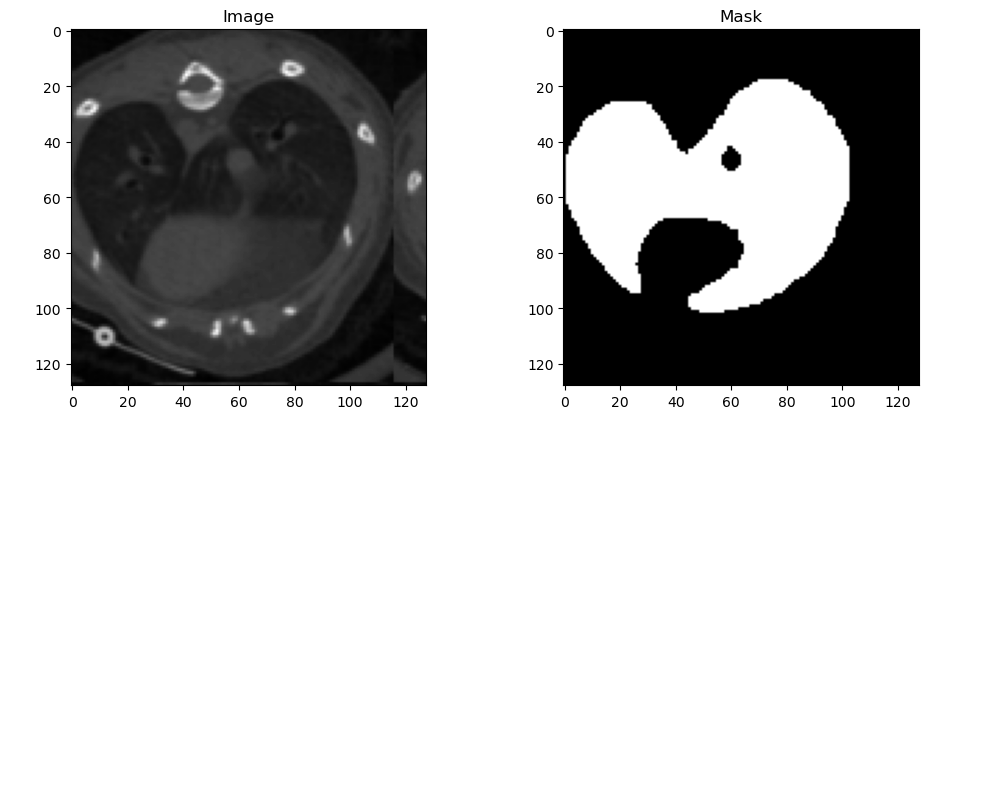

In [16]:
n = 10
X_batch = X[n,:,:,:]
X_img = X_batch[:,:,0]

y_batch = y[n,:,:,:]
y_img_1 = y_batch[:,:,1]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(X_img, cmap='gray')
axs[0, 0].set_title('Image')

axs[0, 1].imshow(y_img_1, cmap='gray')
axs[0, 1].set_title('Mask')

axs[1, 0].axis('off')  # Hide the empty subplot
axs[1, 1].axis('off')  # Hide the empty subplot

plt.tight_layout()
plt.show()

In [5]:
model = models.unet_3plus_2d((128, 128, 1), n_labels=2, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, name='unet3plus')
model.summary()

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 unet3plus_down0_0 (Conv2D)     (None, 128, 128, 64  576         ['input_4[0][0]']                
                                )                                                                 
             

                                                                                                  
 unet3plus_down3_conv_1_bn (Bat  (None, 16, 16, 512)  2048       ['unet3plus_down3_conv_1[0][0]'] 
 chNormalization)                                                                                 
                                                                                                  
 unet3plus_down3_conv_1_activat  (None, 16, 16, 512)  0          ['unet3plus_down3_conv_1_bn[0][0]
 ion (ReLU)                                                      ']                               
                                                                                                  
 unet3plus_up_0_en0_trans_conv   (None, 32, 32, 64)  294976      ['unet3plus_down3_conv_1_activati
 (Conv2DTranspose)                                               on[0][0]']                       
                                                                                                  
 unet3plus

 unet3plus_down_from1_to1_0 (Co  (None, 64, 64, 64)  36864       ['unet3plus_up_1_en1_activation[0
 nv2D)                                                           ][0]']                           
                                                                                                  
 unet3plus_down_from1_to2_0 (Co  (None, 64, 64, 64)  73728       ['unet3plus_down1_conv_1_activati
 nv2D)                                                           on[0][0]']                       
                                                                                                  
 unet3plus_down_from1_to0_0_bn   (None, 64, 64, 64)  256         ['unet3plus_down_from1_to0_0[0][0
 (BatchNormalization)                                            ]']                              
                                                                                                  
 unet3plus_down_from1_to1_0_bn   (None, 64, 64, 64)  256         ['unet3plus_down_from1_to1_0[0][0
 (BatchNor

 (BatchNormalization)           )                                ]']                              
                                                                                                  
 unet3plus_down_from2_to0_0_act  (None, 128, 128, 64  0          ['unet3plus_down_from2_to0_0_bn[0
 ivation (ReLU)                 )                                ][0]']                           
                                                                                                  
 unet3plus_down_from2_to1_0_act  (None, 128, 128, 64  0          ['unet3plus_down_from2_to1_0_bn[0
 ivation (ReLU)                 )                                ][0]']                           
                                                                                                  
 unet3plus_down_from2_to2_0_act  (None, 128, 128, 64  0          ['unet3plus_down_from2_to2_0_bn[0
 ivation (ReLU)                 )                                ][0]']                           
          

In [16]:
#hyper-parameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from your_model import create_neural_network  # Import your neural network model

# Define hyperparameter ranges
param_grid = {
    'batch_size': [16, 32, 64, 128],
    'lr': [0.001, 0.01, 0.1, 0.2],
}

# Create your neural network model
model = model

# Define a function to calculate accuracy or other performance metrics
def calculate_performance(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=calculate_performance)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_batch_size = grid_search.best_params_['batch_size']
best_lr = grid_search.best_params_['lr']

# Print the best hyperparameters
print("Best Batch Size:", best_batch_size)
print("Best Learning Rate (lr):", best_lr)


In [17]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Define the patience values for each monitored quantity
patience_loss = 6
patience_val_loss = 6

# Set the file path for saving the best model based on training loss
filepath_loss = "csc_kid_up_in_train.h5"

# Set the file path for saving the best model based on validation loss
filepath_val_loss = "csc_kid_up_in_val.h5"

# Define the ModelCheckpoint callbacks for each monitored quantity
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define the EarlyStopping callbacks for each monitored quantity
early_stopping_loss = EarlyStopping(monitor='loss', patience=patience_loss)
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=patience_val_loss)

# Create a list of callbacks for each monitored quantity
callbacks_list_loss = [checkpoint_loss, early_stopping_loss]
callbacks_list_val_loss = [checkpoint_val_loss, early_stopping_val_loss]

# Create a TimingCallback to measure the training time
#cb = TimingCallback()
callbacks_list = callbacks_list_loss+callbacks_list_val_loss

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [19]:
# Train model on dataset
history = model.fit(training_generator, epochs = 200,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[callbacks_list])

Epoch 1/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0549 - dice_coef: 0.9721
Epoch 1: loss improved from inf to 0.05486, saving model to csc_kid_up_in_train.h5

Epoch 1: val_loss improved from inf to 0.07716, saving model to csc_kid_up_in_val.h5
4419/4419 [==============================] - 1043s 234ms/step - loss: 0.0549 - dice_coef: 0.9721 - val_loss: 0.0772 - val_dice_coef: 0.9607
Epoch 2/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0376 - dice_coef: 0.9808
Epoch 2: loss improved from 0.05486 to 0.03759, saving model to csc_kid_up_in_train.h5

Epoch 2: val_loss improved from 0.07716 to 0.06548, saving model to csc_kid_up_in_val.h5
4419/4419 [==============================] - 832s 188ms/step - loss: 0.0376 - dice_coef: 0.9808 - val_loss: 0.0655 - val_dice_coef: 0.9666
Epoch 3/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0350 - dice_coef: 0.9822
Epoch 3: loss improved from 0.03759 to 0.03497, saving model to csc_kid_up_

In [22]:
#epoch_times = history.history['epoch_times']
val_losses = history.history['val_loss']
train_losses = history.history['loss']
val_dice = history.history['val_dice_coef']  # Replace with the actual key for validation dice score
train_dice = history.history['dice_coef']  # Replace with the actual key for training dice score

In [23]:
import pandas as pd
data = pd.DataFrame({
    'Epoch': range(1, len(val_losses) + 1),
    'Val Loss': val_losses,
    'Train Loss': train_losses,
    'Val Dice': val_dice,
    'Train Dice': train_dice
})

# Export the DataFrame to an Excel file
data.to_excel(r"D:\Results_CK\unet++var\gn_only\cys\train.xlsx", index=False)

# Prediction 

In [7]:
#get the images
def gather_images(data_path):
    images = [f for f in os.listdir(data_path) if '_M' in f]
    return images

In [4]:
#define custom objects
def Hausdorff_distance(y_true, y_pred, smooth=100):
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(self, y_true, y_pred):
    loss = 1 - self._dice_coef(y_true, y_pred)
    return loss

class GELU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, inputs):
        return 0.5 * inputs * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))))

In [8]:
#load weights
model = keras.models.load_model(r"C:\Users\UAB\Downloads\csc_kid_up_in_val.h5", custom_objects={
                       'jaccard_distance': Hausdorff_distance,
                       'dice_coef_loss': dice_coef_loss,
                       'dice_coef': dice_coef, 'InstanceNormalization':InstanceNormalization, 'GELU': GELU}) #load the weights

model_name = 'test'  #give a name of your choice
data_path = r"D:\Data_128\data\\"  #set the path to masks and imgaes
images = gather_images(data_path) #get the input images using the defined functions
print(len(images))  #check if the images are gathered correctly
print(images[2000])
print(images[0:2])

79307
110080_2_87_L_82_M.npy
['101934_0_96_L_0_M.npy', '101934_0_96_L_10_M.npy']


In [9]:
label_mapping = {name: index for index, name in enumerate(images)} #map the labels for prediction
labels = {name: label_mapping[name] for name in image_list}

In [11]:
#the below code does the prediction by passing the test images 
import numpy
import nibabel


label_list = []
predictions = []
pred_path1 = r"D:\npy"   #to save predictions as npy
pred_path2 = r"D:\t"     #to save tensors as npy
pred_path3 = r"D:\Results_CK\unet++var\in\kid\nii"   #to save final predictions as nii
# Check if the directory exists
if not os.path.exists(pred_path1):
    # Create the directory
    os.makedirs(pred_path1)
    print(f"Directory '{pred_path1}' created.")
else:
    print(f"Directory '{pred_path1}' already exists.")
if not os.path.exists(pred_path2):
    # Create the directory
    os.makedirs(pred_path2)
    print(f"Directory '{pred_path2}' created.")
else:
    print(f"Directory '{pred_path2}' already exists.")
if not os.path.exists(pred_path3):
    # Create the directory
    os.makedirs(pred_path3)
    print(f"Directory '{pred_path3}' created.")
else:
    print(f"Directory '{pred_path3}' already exists.")
#pred_path2 = r"D:\NII" #optional - if u want to convert npy to nii
images = image_list

for i, image in enumerate(images):
    image_stack = np.empty((1, 128, 128, 1))  # create a tensor to hold images
    image = np.load(os.path.join(data_path, image))
    image_stack[0, ..., 0] = image  #assign the image as a part of stack
    label_match = str(images[i][:-5] + 'C.npy') #match label
    label_list.append(label_match)

    img_prediction = model.predict(image_stack)  #model prediction

    for z, img_pred in enumerate(img_prediction): #saving the prediction as nii or npy
        img_numb = z + i
        image_save = img_pred[:, :]  #removing extra axis from the predicted image
        label = label_list[img_numb][:-5]
        filename = f"{label}{model_name}_P.npy"
        filename1 = f"{label}{model_name}_P.nii"
        np.save(os.path.join(pred_path1, filename), image_save)
        #the below code is optional if the above npy have to be saved as nii (2D)
        #image = np.load(os.path.join(pred_path1, filename))
        #affine = numpy.eye(4)
        #nifti_file = nibabel.Nifti1Image(image_save, affine)
        #nib.save(nifti_file, os.path.join(pred_path2, filename1))

Directory 'D:\npy' already exists.
Directory 'D:\t' already exists.
Directory 'D:\Results_CK\unet++var\in\kid\nii' already exists.


# Performance Calculation

In [12]:
import numpy as np
from keras import backend as K
smooth = 1

def jaccard_distance_loss(y_true, y_pred, smooth=100): 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f)) 
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f)) 
    jac = (intersection + smooth) / (sum_ - intersection + smooth) 
    return (jac) * smooth 

def mean_length_error(y_true, y_pred):
    y_true_f = K.sum(K.round(K.flatten(y_true)))
    y_pred_f = K.sum(K.round(K.flatten(y_pred)))
    delta = (y_pred_f - y_true_f)
    return K.mean(K.tanh(delta))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [13]:
def gather_set(data_path, phrase):
    return np.array([f for f in os.listdir(data_path) if phrase in f])

In [14]:
#filepath_predictions = r'D:\Results_CK\Compression\Numpy\PCA\Kidneys\npy'
filepath_predictions = r"D:\npy"     #2d Predictions
filepath_tensors = r"D:\t"           #3D tensors
filepath_data = r"D:\Data_128\data\\"   #Input images path

images = gather_set(filepath_predictions, 'P')
model_name = 'test'

In [15]:
id_list = []   
for i in range(len(images)):
    image_name = images[i]
    unique_id =  image_name[0:14]
    id_list.append(unique_id)
unique_ids = list(set(id_list))
for i in range(len(unique_ids)):
    name = unique_ids[i] 
    if not name.endswith('_'):
        name = name+'_'
        unique_ids[i]=name

In [16]:
import re
for i in range(len(unique_ids)):
    pt_info = unique_ids[i]
    pt_num, yr_num, num_slices = re.findall(r'\d+', pt_info)
    tensor = np.zeros((128,128,int(num_slices)))
    for x in range(int(num_slices)):
        img_name = unique_ids[i]+str(x)+'_K.npy'
        image = np.load(filepath_data + '\\' + img_name)
        img_slice = image
        tensor[:,:,x] = img_slice
        x = x+1
    new_fname = unique_ids[i]+'K.npy'
    np.save(os.path.join(filepath_tensors, new_fname), tensor)
    
for i in range(len(unique_ids)):
    pt_info = unique_ids[i]
    pt_num, yr_num, num_slices = re.findall(r'\d+', pt_info)
    tensor = np.zeros((128,128,int(num_slices)))
    for x in range(int(num_slices)):
        img_name = unique_ids[i]+str(x)+ '_' + model_name +'_P.npy'
        image = np.load(filepath_predictions + '\\' + img_name)
        img_slice = image[:,:,1]
        tensor[:,:,x] = img_slice
        x = x+1
    new_fname = unique_ids[i]+ model_name +'_Prediction.npy'
    np.save(os.path.join(filepath_tensors, new_fname), tensor)

In [17]:
filepath_tensors = filepath_tensors
pred_list = gather_set(filepath_tensors, '_Prediction')
true_list = gather_set(filepath_tensors, '_K.')

In [18]:
results1 = []
results = []
for i in range(len(pred_list)):
    prediction = np.load(filepath_tensors + '\\'+ pred_list[i])
    true = np.load(filepath_tensors + '\\'+true_list[i])
    dice_calc = dice_coef(true,prediction)
    #model = pred_list[i][18:46]
    patient = pred_list[i][:17]
    new_calc = [dice_calc.numpy()]
    new_calc1 = [patient, dice_calc.numpy()]
    #new_calc = [dice_calc.numpy()]
    results.append(new_calc)
    results1.append(new_calc1)

In [19]:
min_values = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_min = min(col_values)
    min_values.append(col_min)

# patient_min = min_values[0]  # Minimum value of patient values
dice_calc_min = min_values[0]  # Minimum value of dice_calc values
print(dice_calc_min)

for i in results1:
    if min_values[0] in i:
        print(i)

min_values = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_min = max(col_values)
    min_values.append(col_min)

# patient_min = min_values[0]  # Minimum value of patient values
dice_calc_min = min_values[0]  # Minimum value of dice_calc values
print(dice_calc_min)

for i in results1:
    if min_values[0] in i:
        print(i)

0.8420158775506565
['457036_1_105_L_te', 0.8420158775506565, 2.890796672077761, <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float64, numpy=0.048576459026784896>>, 0.727225254878882, 0.17088681175595238]
0.9438279759329913
['457036_3_111_R_te', 0.9438279759329913, 1.6253005544585577, <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float64, numpy=0.014525277860202525>>, 0.8936711914936278, 0.13629590283643017]


In [20]:
averages = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_avg = sum(col_values) / len(col_values)
    averages.append(col_avg)

#patient_avg = averages[0]  # Average of patient values
dice_calc_avg = averages[0]  # Average of dice_calc values
print("Dice Coefficient Average:", dice_calc_avg)

Dice Coefficient Average: 0.8974605453403786
HD Distance Average: 2.2557731120159104
HD1 Distance Average: 0.031109551249895107
Jaccard Distance Average: 0.8160556349815984
IOU Distance Average: 0.15251781605999135


In [34]:
import math

# Calculate standard deviation for each parameter
dice_calc_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - dice_calc_avg) ** 2 for val in results[0]) / len(results[0])

# Print standard deviation values
print("Dice Coefficient Standard Deviation:", dice_calc_sd)

Dice Coefficient Standard Deviation: 0.3618699014701029
HD Distance Standard Deviation: 0.840657460632272
HD1 Distance Standard Deviation: 0.938614203495385
Jaccard Distance Standard Deviation: 0.4542534629573794
IOU Distance Standard Deviation: 0.9258641438623455


In [36]:
def gather_images(data_path):
    return np.array([f for f in os.listdir(data_path) if '_test' in f])

In [37]:
filepath_tensors = r"D:\Results_CK\unet++var\in\kid\t"
images = gather_images(filepath_tensors)
print(len(images))
path = r"D:\Results_CK\unet++var\in\kid\nii"
for i in range(len(images)):
    image = np.load(os.path.join(filepath_tensors, images[i]))
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(image, affine)
    filename = images[i][:-3]+'nii'
    nib.save(nifti_file, os.path.join(path, filename))

76
